## Run the models again on the emails

In [ ]:
import yaml
import time
from datetime import datetime
import schedule
from megadetector.detection import run_detector
import pandas as pd
import functools

# Adjust the path as needed to point to the directory containing alert_system_utils.py
import sys
sys.path.append('../scripts') 

from alert_system_utils import (
    detector,
    classifier,
    set_device,
    check_emails,
    extract_and_update_camera_info,
    update_camera_data_dataframe,
    batch_classification,
    current_time,
    generate_alert_caption,
    detections_in_sequence,
    send_alert_to_telegram,
    save_images,
    annotate_images,
    send_weekly_report
)


# Load settings from configuration file
with open('../config.yaml') as file:
    config = yaml.safe_load(file)

IMAP_HOST = config['imap_config']['host']
EMAIL_USER = config['imap_config']['user']
EMAIL_PASS = config['imap_config']['password']

TELEGRAM_BOT_TOKEN = config['telegram_config']['bot_token']
TELEGRAM_CHAT_ID =  '-1002249589791' # config['telegram_config']['chat_id']  #  replace with config after tests # 

SMTP_SERVER = config['smtp_config']['host']
EMAIL_SENDER = config['smtp_config']['user']
EMAIL_PASSWORD = config['smtp_config']['password']
RECIPIENTS = config['smtp_config']['recipients']

SMTP_PORT = 587

# Detection and Classification Model Settings
DETECTOR_MODEL_PATH = '../models/md_v5a.0.0.pt'
DETECTOR_CLASSES = ["animal", "human", "vehicle"]
DETECTION_THRESHOLD = 0.15

BACKBONE = 'vit_large_patch14_dinov2'

# CLASSIFIER_MODEL_PATH = '../models/deepfaune-vit_large_patch14_dinov2.lvd142m.pt'
CLASSIFIER_MODEL_PATH = '../models/2024-06-14-03-34-55-deepfaune-finetuned-epochs-30-lr-1e-06-wbpenalty-10.0.pt'
CLASSIFIER_CLASSES = [
    "Badger", "Ibex", "Red Deer", "Chamois", "Cat",
    "Goat", "Roe Deer", "Dog", "Squirrel", "Equid", "Genet",
    "Hedgehog", "Lagomorph", "Wolf", "Lynx", "Marmot",
    "Micromammal", "Mouflon", "Sheep", "Mustelid", "Bird",
    "Bear", "Nutria", "Fox", "Wild Boar", "Cow"
]
ROMANIAN_CLASSES = [
    "Bursuc", "Ibex", "Cerb", "Capră Neagră", "Pisică", 
    "Capră", "Căprioară", "Câine", "Veveriță", "Cal", "Genetă",
    "Arici", "Iepuri", "Lup", "Râs", "Marmotă", 
    "Micromamifer", "Muflon", "Oaie", "Mustelid", "Pasăre", 
    "Urs", "Nutrie", "Vulpe", "Mistreț", "Vacă"
]
SPECIES_OF_INTEREST = ["Wild Boar", "Bear"]
CLASSIFICATION_THRESHOLD = 0.20

CAPTURE_DATABASE_PATH = '../data/capture_database.csv'
CAMERA_LOCATIONS_PATH = '../data/camera_locations.csv'
PHOTOS_PATH = '../data/photos/'
ALERT_LANGUAGE = "ro" # Enter 'en' for English, 'ro' for Romanian
HUMAN_ALERT_START = "21:00"
HUMAN_ALERT_END = "06:00"
CHECK_EMAIL_FREQUENCY = 1

# Initialise the Detection and Classifier Models
device = set_device()
detector_model = run_detector.load_detector(DETECTOR_MODEL_PATH)
print("Loading classifier...")
start_time = time.time()
classifier_model = classifier(CLASSIFIER_MODEL_PATH, BACKBONE, CLASSIFIER_CLASSES, device)
end_time = time.time()
print(f"Loaded classifier in {(end_time - start_time):.2f} seconds")

schedule.every().monday.at("08:00").do(
    functools.partial(send_weekly_report, SMTP_SERVER, EMAIL_SENDER, EMAIL_PASSWORD, SMTP_PORT, CAPTURE_DATABASE_PATH, CAMERA_LOCATIONS_PATH, RECIPIENTS, EMAIL_USER)
)


if __name__ == "__main__":
    print(f"\n{current_time()} | Monitoring {EMAIL_USER} for new messages...")
    while True:
        try:
            images, original_images, camera_id, temp_deg_c, img_date, img_time, battery, sd_memory = \
                check_emails(IMAP_HOST, EMAIL_USER, EMAIL_PASS)
            if camera_id:
                camera_make, gps, location, map_url, battery, sd_memory = extract_and_update_camera_info(CAMERA_LOCATIONS_PATH, camera_id, battery, sd_memory)
                if images:
                    df = pd.read_csv(CAPTURE_DATABASE_PATH)
                    df = update_camera_data_dataframe(df, len(images), camera_id, camera_make, img_date, img_time, temp_deg_c, battery, sd_memory, location, gps, map_url)
                    df, human_warning = detector(df, detector_model, images, DETECTION_THRESHOLD)
                    df = batch_classification(df, classifier_model, images, CLASSIFICATION_THRESHOLD)
                    if detections_in_sequence(df, images):
                        df, alert_caption = generate_alert_caption(df, human_warning, HUMAN_ALERT_START, HUMAN_ALERT_END, len(images), SPECIES_OF_INTEREST, EMAIL_USER, ALERT_LANGUAGE, CLASSIFIER_CLASSES, ROMANIAN_CLASSES)
                        
                        ### DELETE ME ####
                        human_warning = False
                        
                        # alert_images = annotate_images(df, images, human_warning, HUMAN_ALERT_START, HUMAN_ALERT_END, ALERT_LANGUAGE, CLASSIFIER_CLASSES, ROMANIAN_CLASSES)

                        # send_alert_to_telegram(TELEGRAM_BOT_TOKEN, TELEGRAM_CHAT_ID, alert_images, alert_caption)
                    else:
                        print(f"{current_time()} | All photos in sequence are empty")
                    df = save_images(df, original_images, human_warning, PHOTOS_PATH)
                    df.to_csv(CAPTURE_DATABASE_PATH, index=False)
                    print(f"{current_time()} | Capture database updated: {CAPTURE_DATABASE_PATH}")
                    del df
                else:
                    print(f"{current_time()} | No images attached to email")
                print(f"\n{current_time()} | Monitoring {EMAIL_USER} for new messages...")
            else:
                time.sleep(CHECK_EMAIL_FREQUENCY)
            schedule.run_pending()
        except KeyboardInterrupt:
            print(f"{current_time()} | Interrupted by user")
            break

        except Exception as e:
            print(f"{current_time()} | An error occurred: {e}")
            time.sleep(CHECK_EMAIL_FREQUENCY)
            print(f"\n{current_time()} | Monitoring {EMAIL_USER} for new messages...")
            continue


## Manually label each image received

In [ ]:
import pandas as pd
from IPython.display import display, clear_output
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Load the data
file_path = '../data/field_tests/capture_database_deep_faune.csv'
df = pd.read_csv(file_path)

# Function to display image with text overlay
def display_image_with_text(row, current_index, total_images):
    clear_output(wait=True)  # Clear the output to remove the last image
    img = PILImage.open(row['File Path'])
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img)
    
    # Text annotations
    progress_str = f"Image [{current_index}] of [{total_images}]"
    counts = []
    if row['Animal Count'] > 0: counts.append(f"Animals: {row['Animal Count']}")
    if row['Wild Boar Count'] > 0: counts.append(f"Boars: {row['Wild Boar Count']}")
    if row['Bear Count'] > 0: counts.append(f"Bears: {row['Bear Count']}")
    if row['Human Count'] > 0: counts.append(f"Humans: {row['Human Count']}")
    if row['Vehicle Count'] > 0: counts.append(f"Vehicles: {row['Vehicle Count']}")
    counts_str = ", ".join(counts)
    labels_str = f"{row['Primary Species']} | {counts_str}"
    text_str = f"{progress_str}\n{labels_str}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.5, 0.95, text_str, transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='top', bbox=props, color='red', fontweight='bold')
    
    plt.axis('off')  # Turn off axis
    plt.show()       # Show the image with annotations

# Filter to only rows needing manual labeling where Ground_Truth is NaN
df_to_label = df[df['Ground_Truth Primary Species'].isna()].copy()

# Sort the df_to_label by 'Primary Species' in alphabetical order
df_to_label.sort_values(by='Primary Species', inplace=True)

total_images = len(df_to_label)

# Iterate through dataframe rows needing manual labeling
current_index = 0
while current_index < total_images:
    row = df_to_label.iloc[current_index]
    display_image_with_text(row, current_index + 1, total_images)
    
    valid_inputs = {'y', 'n', 'b'}
    user_input = ""
    
    while user_input not in valid_inputs:
        user_input = input("Is the information correct? Enter 'y' for yes, 'n' for no, 'b' to go back: ").strip().lower()
    
    if user_input == 'y':
        df.at[row.name, 'Ground_Truth Primary Species'] = row['Primary Species']
        df.at[row.name, 'Ground_Truth Animal Count'] = row['Animal Count']
        df.at[row.name, 'Ground_Truth Wild Boar Count'] = row['Wild Boar Count']
        df.at[row.name, 'Ground_Truth Bear Count'] = row['Bear Count']
        df.at[row.name, 'Ground_Truth Human Count'] = row['Human Count']
        df.at[row.name, 'Ground_Truth Vehicle Count'] = row['Vehicle Count']
        current_index += 1
    elif user_input == 'n':
        ground_truth_species = input("Enter Ground Truth Primary Species: ")
        ground_truth_animal_count = input("Enter Ground Truth Animal Count: ")
        ground_truth_wild_boar_count = input("Enter Ground Truth Wild Boar Count: ")
        ground_truth_bear_count = input("Enter Ground Truth Bear Count: ")
        ground_truth_human_count = input("Enter Ground Truth Human Count: ")
        ground_truth_vehicle_count = input("Enter Ground Truth Vehicle Count: ")
        
        df.at[row.name, 'Ground_Truth Primary Species'] = ground_truth_species
        df.at[row.name, 'Ground_Truth Animal Count'] = ground_truth_animal_count
        df.at[row.name, 'Ground_Truth Wild Boar Count'] = ground_truth_wild_boar_count
        df.at[row.name, 'Ground_Truth Bear Count'] = ground_truth_bear_count
        df.at[row.name, 'Ground_Truth Human Count'] = ground_truth_human_count
        df.at[row.name, 'Ground_Truth Vehicle Count'] = ground_truth_vehicle_count
        current_index += 1
    elif user_input == 'b':
        if current_index > 0:
            current_index -= 1

print("Labeling completed.")

# Save the DataFrame to the new file path
df.to_csv("../data/field_tests/ground_truth.csv", index=False)


## Create precision/recall tables for each model

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = '/home/tom-ratsakatika/VSCode/camera-traps/data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Filter the dataframe, removing rows where the ground truth = Unknown
df_filtered = df[df['Ground_Truth Primary Species'] != 'Unknown']

# Define the ground truth and model predictions
ground_truth = df_filtered['Ground_Truth Primary Species']
models = {
    'Deep_Faune': df_filtered['Deep_Faune Primary Species'],
    'Balanced_Loss': df_filtered['Balanced_Loss Primary Species'],
    'Biased_Loss': df_filtered['Biased_Loss Primary Species']
}

# Create a dictionary to store the classification reports
reports = {}

# Generate classification reports for each model
for model_name, predictions in models.items():
    report = classification_report(ground_truth, predictions, zero_division=0, output_dict=True)
    reports[model_name] = report

# Convert the classification reports into dataframes for better readability
report_dfs = {model_name: pd.DataFrame(report).transpose() for model_name, report in reports.items()}

# Function to save the classification report to CSV
def save_report_to_csv(report_df, model_name):
    report_df.to_csv(f'{model_name}_classification_report.csv')

# Save the classification reports for each model to CSV files
for model_name, report_df in report_dfs.items():
    save_report_to_csv(report_df, model_name)
    print(f"Classification Report for {model_name} saved as {model_name}_classification_report.csv")


### Combined tables for species of interest

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = '../data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Filter the dataframe, removing rows where the ground truth = Unknown
df_filtered = df[df['Ground_Truth Primary Species'] != 'Unknown']

# Define the ground truth and model predictions
ground_truth = df_filtered['Ground_Truth Primary Species']
models = {
    'Deep_Faune': df_filtered['Deep_Faune Primary Species'],
    'Balanced_Loss': df_filtered['Balanced_Loss Primary Species'],
    'Biased_Loss': df_filtered['Biased_Loss Primary Species']
}

# List of specified animals
specified_animals = ['Badger', 'Bear', 'Fox', 'Red Deer', 'Roe Deer', 'Wild Boar']

# Create a dictionary to store the classification reports
reports = {}

# Generate classification reports for each model, only for the specified animals
for model_name, predictions in models.items():
    report = classification_report(ground_truth, predictions, labels=specified_animals, zero_division=0, output_dict=True)
    reports[model_name] = pd.DataFrame(report).transpose()

# Combine the reports into a single table
combined_report = pd.concat(reports, axis=1)

combined_report.to_csv('../data/field_tests/combined_report.csv', index=True)

# Display the combined report
combined_report



### Combined tables for all species

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = '../data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Filter the dataframe, removing rows where the ground truth = Unknown
df_filtered = df[df['Ground_Truth Primary Species'] != 'Unknown']

# Define the ground truth and model predictions
ground_truth = df_filtered['Ground_Truth Primary Species']
models = {
    'Deep_Faune': df_filtered['Deep_Faune Primary Species'],
    'Balanced_Loss': df_filtered['Balanced_Loss Primary Species'],
    'Biased_Loss': df_filtered['Biased_Loss Primary Species']
}

# Create a dictionary to store the classification reports
reports = {}

# Generate classification reports for each model for all species
for model_name, predictions in models.items():
    report = classification_report(ground_truth, predictions, zero_division=0, output_dict=True)
    reports[model_name] = pd.DataFrame(report).transpose()

# Combine the reports into a single table
combined_report = pd.concat(reports, axis=1)

# Save the combined report to a CSV file
combined_report.to_csv('../data/field_tests/combined_report.csv', index=True)

# Display the combined report
combined_report


### Separate tables for species of interest

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = '/home/tom-ratsakatika/VSCode/camera-traps/data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Filter the dataframe, removing rows where the ground truth = Unknown
df_filtered = df[df['Ground_Truth Primary Species'] != 'Unknown']

# Define the ground truth and model predictions
ground_truth = df_filtered['Ground_Truth Primary Species']
models = {
    'Deep_Faune': df_filtered['Deep_Faune Primary Species'],
    'Balanced_Loss': df_filtered['Balanced_Loss Primary Species'],
    'Biased_Loss': df_filtered['Biased_Loss Primary Species']
}

# List of specified animals
specified_animals = ['Bear', 'Wild Boar', 'Badger', 'Fox', 'Red Deer', 'Roe Deer']

# Create dictionaries to store the classification reports for precision, recall, and F1 score
precision_reports = {}
recall_reports = {}
f1_reports = {}
support_reports = {}

# Generate classification reports for each model, only for the specified animals
for model_name, predictions in models.items():
    report = classification_report(ground_truth, predictions, labels=specified_animals, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    precision_reports[model_name] = report_df[['precision']]
    recall_reports[model_name] = report_df[['recall']]
    f1_reports[model_name] = report_df[['f1-score']]
    support_reports[model_name] = report_df[['support']]

# Combine the reports into single tables for precision, recall, and F1 score
combined_precision = pd.concat(precision_reports, axis=1)
combined_recall = pd.concat(recall_reports, axis=1)
combined_f1 = pd.concat(f1_reports, axis=1)

# Use support from one of the reports as it is the same for all models
support = support_reports[list(models.keys())[0]]
support.columns = ['n']

# Insert support as the second column in each combined table
combined_precision.insert(0, 'n', support)
combined_recall.insert(0, 'n', support)
combined_f1.insert(0, 'n', support)

# Round the scores to 4 decimal places
combined_precision = combined_precision.round(4)
combined_recall = combined_recall.round(4)
combined_f1 = combined_f1.round(4)

# Display the combined reports
print("Combined Precision Table:")
print(combined_precision)
print("\nCombined Recall Table:")
print(combined_recall)
print("\nCombined F1 Score Table:")
print(combined_f1)


### Separate tables for all species

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = '/home/tom-ratsakatika/VSCode/camera-traps/data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Filter the dataframe, removing rows where the ground truth = Unknown
df_filtered = df[df['Ground_Truth Primary Species'] != 'Unknown']

# Define the ground truth and model predictions
ground_truth = df_filtered['Ground_Truth Primary Species']
models = {
    'Deep_Faune': df_filtered['Deep_Faune Primary Species'],
    'Balanced_Loss': df_filtered['Balanced_Loss Primary Species'],
    'Biased_Loss': df_filtered['Biased_Loss Primary Species']
}

# Create dictionaries to store the classification reports for precision, recall, and F1 score
precision_reports = {}
recall_reports = {}
f1_reports = {}
support_reports = {}

# Generate classification reports for each model for all species
for model_name, predictions in models.items():
    report = classification_report(ground_truth, predictions, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    precision_reports[model_name] = report_df[['precision']]
    recall_reports[model_name] = report_df[['recall']]
    f1_reports[model_name] = report_df[['f1-score']]
    support_reports[model_name] = report_df[['support']]

# Combine the reports into single tables for precision, recall, and F1 score
combined_precision = pd.concat(precision_reports, axis=1)
combined_recall = pd.concat(recall_reports, axis=1)
combined_f1 = pd.concat(f1_reports, axis=1)

# Use support from one of the reports as it is the same for all models
support = support_reports[list(models.keys())[0]]
support.columns = ['n']

# Insert support as the second column in each combined table
combined_precision.insert(0, 'n', support)
combined_recall.insert(0, 'n', support)
combined_f1.insert(0, 'n', support)

# Round the scores to 4 decimal places
combined_precision = combined_precision.round(4)
combined_recall = combined_recall.round(4)
combined_f1 = combined_f1.round(4)

# Save the combined reports to CSV files
combined_precision.to_csv('../data/field_tests/combined_precision.csv', index=True)
combined_recall.to_csv('../data/field_tests/combined_recall.csv', index=True)
combined_f1.to_csv('../data/field_tests/combined_f1.csv', index=True)

# Display the combined reports
print("Combined Precision Table:")
print(combined_precision)
print("\nCombined Recall Table:")
print(combined_recall)
print("\nCombined F1 Score Table:")
print(combined_f1)


## Results for pilot only

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the CSV file
file_path = '../data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Combine Date and Time into a single Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Define the pilot stage end date
pilot_end_date = '2024-05-28'

# Filter the dataframe for the pilot stage
df_pilot = df[df['Date'] <= pilot_end_date]

# Further filter the dataframe, removing rows where the ground truth = Unknown
df_filtered = df_pilot[df_pilot['Ground_Truth Primary Species'] != 'Unknown']

# Define the ground truth and model predictions
ground_truth = df_filtered['Ground_Truth Primary Species']
models = {
    'Deep_Faune': df_filtered['Deep_Faune Primary Species'],
    'Balanced_Loss': df_filtered['Balanced_Loss Primary Species'],
    'Biased_Loss': df_filtered['Biased_Loss Primary Species']
}

# List of specified animals
specified_animals = ['Badger', 'Bear', 'Fox', 'Red Deer', 'Roe Deer', 'Wild Boar']

# Create a dictionary to store the classification reports
reports = {}

# Generate classification reports for each model, only for the specified animals
for model_name, predictions in models.items():
    report = classification_report(ground_truth, predictions, labels=specified_animals, zero_division=0, output_dict=True)
    reports[model_name] = pd.DataFrame(report).transpose()

# Combine the reports into a single table
combined_report = pd.concat(reports, axis=1)

# Display the combined report
combined_report


## Plot photos over time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure plots are displayed in the notebook
%matplotlib inline

# Load the CSV file
file_path = '/home/tom-ratsakatika/VSCode/camera-traps/data/field_tests/ground_truth.csv'
df = pd.read_csv(file_path)

# Parse Date and Time columns into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert 'Ground_Truth Animal Count' to numeric, forcing errors to NaN (if any), and then fill NaNs with 0
df['Ground_Truth Animal Count'] = pd.to_numeric(df['Ground_Truth Animal Count'], errors='coerce').fillna(0)

# Filter the DataFrame for the specified animals
animals = ['Badger', 'Bear', 'Fox', 'Red Deer', 'Roe Deer', 'Wild Boar']
filtered_df = df[df['Ground_Truth Primary Species'].isin(animals)]

# Add "Others" category using .loc to avoid SettingWithCopyWarning
filtered_df.loc[~filtered_df['Ground_Truth Primary Species'].isin(animals), 'Ground_Truth Primary Species'] = 'Others'

# Sort the DataFrame by Datetime
filtered_df = filtered_df.sort_values(by='Datetime')

# Calculate the cumulative count of animals over time
cumulative_count = filtered_df.groupby(['Datetime', 'Ground_Truth Primary Species'])['Ground_Truth Animal Count'].sum().groupby(level=1).cumsum().reset_index()

# Plot the cumulative count of each species over time
plt.figure(figsize=(14, 7))
for animal in animals + ['Others']:
    animal_data = cumulative_count[cumulative_count['Ground_Truth Primary Species'] == animal]
    plt.plot(animal_data['Datetime'], animal_data['Ground_Truth Animal Count'], label=animal)
    
    # Mark the last point and add a label showing the cumulative total
    if not animal_data.empty:
        last_point = animal_data.iloc[-1]
        plt.scatter(last_point['Datetime'], last_point['Ground_Truth Animal Count'], s=100)
        plt.text(last_point['Datetime'], last_point['Ground_Truth Animal Count'], f"{last_point['Ground_Truth Animal Count']}", fontsize=12, ha='right')

plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Count of Animal Species Over Time')
plt.legend()
plt.grid(True)
plt.show()


## Define unique detection events

In [ ]:
import pandas as pd

# Define the path to the CSV file
file_path = '../data/field_tests/ground_truth.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Create a column for the original index to maintain the original order
df['Original_Index'] = df.index

# Sort the DataFrame by Datetime
sorted_df = df.sort_values(by=['Datetime']).reset_index(drop=True)

# Initialize the Detection Event ID
event_id = 1
detection_event_ids = [event_id]

# Iterate through the rows to assign Detection Event IDs
for i in range(1, len(sorted_df)):
    current_row = sorted_df.iloc[i]
    previous_row = sorted_df.iloc[i - 1]

    # Check if the current row is within 60 seconds of the previous row and at the same location
    if (current_row['Location'] == previous_row['Location']) and \
       (current_row['Datetime'] - previous_row['Datetime']).total_seconds() <= 60:
        detection_event_ids.append(event_id)
    else:
        event_id += 1
        detection_event_ids.append(event_id)

# Add the Detection Event ID column to the sorted DataFrame
sorted_df['Detection Event ID'] = detection_event_ids

# Function to determine the Detection Event Primary Species
def determine_primary_species(group):
    species_counts = group[group != "Empty"].value_counts()
    if species_counts.empty:
        return "Empty"
    else:
        return species_counts.idxmax()

# Apply the function to assign Detection Event Primary Species
sorted_df['Detection Event Primary Species'] = sorted_df.groupby('Detection Event ID')['Ground_Truth Primary Species'].transform(determine_primary_species)

# Merge the Detection Event ID and Detection Event Primary Species back to the original DataFrame
df = df.merge(sorted_df[['Original_Index', 'Detection Event ID', 'Detection Event Primary Species']], on='Original_Index', how='left')

# Drop the auxiliary columns
df = df.drop(columns=['Original_Index', 'Datetime'])

# Move the 'Detection Event ID' and 'Detection Event Primary Species' columns to the first positions
columns = ['Detection Event ID', 'Detection Event Primary Species'] + [col for col in df.columns if col not in ['Detection Event ID', 'Detection Event Primary Species']]
df = df[columns]

# Sort by original index to maintain the original order
df = df.sort_index()

# Display the DataFrame to verify the new columns
df.head()

# Save the DataFrame with the new columns to a new CSV file (optional)
df.to_csv('../data/field_tests/ground_truth_with_detection_event_id.csv', index=False)


#### View detection events

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, clear_output

# Function to plot photos for a given event ID
def plot_photos(event_id):
    event_df = df[df['Detection Event ID'] == event_id]
    file_paths = event_df['File Path'].values
    
    # Number of images
    num_images = len(file_paths)
    
    # Determine the grid size
    if num_images == 1:
        grid_size = (1, 1)
    elif num_images == 2:
        grid_size = (1, 2)
    elif num_images <= 4:
        grid_size = (2, 2)
    elif num_images <= 6:
        grid_size = (2, 3)
    elif num_images <= 9:
        grid_size = (3, 3)
    else:
        grid_size = (3, 4)
    
    # Create the plot
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for ax, file_path in zip(axes, file_paths):
        img = mpimg.imread(file_path)
        ax.imshow(img)
        ax.axis('off')
    
    # Hide any remaining subplots
    for ax in axes[num_images:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to update the plot based on event ID
def update_output(event_id):
    clear_output(wait=True)
    plot_photos(event_id)

# List of event IDs
event_ids = sorted(df['Detection Event ID'].unique())
current_event_id = event_ids[0]

# Main loop for handling user input
while True:
    update_output(current_event_id)
    user_input = input("Enter 'b' to go back, press Enter to go forward, or 'q' to quit: ").strip().lower()
    if user_input == 'b':
        current_event_id = max(current_event_id - 1, event_ids[0])
    elif user_input == '':
        current_event_id = min(current_event_id + 1, event_ids[-1])
    elif user_input == 'q':
        break


## Analyse detection events

In [18]:
import pandas as pd

# Assume the dataframe 'df' already exists

# Exclude Human, Vehicle, and Unknown from the analysis
exclude_species = ["Human", "Vehicle", "Unknown"]
df_filtered = df[~df['Detection Event Primary Species'].isin(exclude_species)]

# Create a summary table for the camera comparison
summary = {
    'Detection Events': [],
    'W or U': [],
    'W and U': [],
    'W not U': [],
    'U not W': []
}

species_list = ['All Species'] + sorted(df_filtered['Detection Event Primary Species'].unique())

for species in species_list:
    if species == 'All Species':
        total_events = df_filtered['Detection Event ID'].nunique()
        w_events = df_filtered[df_filtered['Camera Make'] == 'Wilsus']['Detection Event ID'].unique()
        u_events = df_filtered[df_filtered['Camera Make'] == 'UOVision']['Detection Event ID'].unique()
    else:
        total_events = df_filtered[df_filtered['Detection Event Primary Species'] == species]['Detection Event ID'].nunique()
        w_events = df_filtered[(df_filtered['Camera Make'] == 'Wilsus') & (df_filtered['Detection Event Primary Species'] == species)]['Detection Event ID'].unique()
        u_events = df_filtered[(df_filtered['Camera Make'] == 'UOVision') & (df_filtered['Detection Event Primary Species'] == species)]['Detection Event ID'].unique()
    
    w_set = set(w_events)
    u_set = set(u_events)
    
    w_or_u = len(w_set | u_set)
    w_and_u = len(w_set & u_set)
    w_not_u = len(w_set - u_set)
    u_not_w = len(u_set - w_set)

    summary['Detection Events'].append(total_events)
    summary['W or U'].append(w_or_u)
    summary['W and U'].append(w_and_u)
    summary['W not U'].append(w_not_u)
    summary['U not W'].append(u_not_w)

summary_df = pd.DataFrame(summary, index=species_list)

# Display the summary table
display(summary_df)

# Optionally, save the summary table to a CSV file
summary_df.to_csv('../data/field_tests/camera_comparison_summary.csv')


,Detection Events,W or U,W and U,W not U,U not W
All Species,328,328,111,89,128
Badger,7,7,0,0,7
Bear,73,73,51,15,7
Bird,22,22,1,8,13
Cat,8,8,2,0,6
Dog,10,10,8,0,2
Empty,135,135,6,63,66
Equid,7,7,7,0,0
Fox,38,38,18,1,19
Lagomorph,2,2,0,0,2


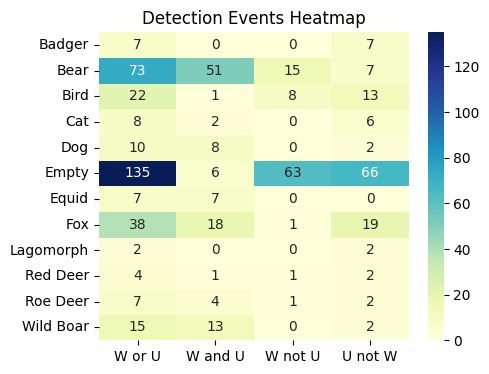

In [19]:
import seaborn as sns

heatmap_data = summary_df[['W or U', 'W and U', 'W not U', 'U not W']][1:]
plt.figure(figsize=(5, 4))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Detection Events Heatmap')
plt.show()


,Detection Events,W or U,W and U,W not U,U not W,W or U (Pilot),W and U (Pilot),W not U (Pilot),U not W (Pilot),W or U (Live),W and U (Live),W not U (Live),U not W (Live)
All Species,328,328,111,89,128,103,22,40,41,225,89,49,87
Badger,7,7,0,0,7,1,0,0,1,6,0,0,6
Bear,73,73,51,15,7,39,19,14,6,34,32,1,1
Bird,22,22,1,8,13,21,1,8,12,1,0,0,1
Cat,8,8,2,0,6,0,0,0,0,8,2,0,6
Dog,10,10,8,0,2,0,0,0,0,10,8,0,2
Empty,135,135,6,63,66,39,0,17,22,96,6,46,44
Equid,7,7,7,0,0,0,0,0,0,7,7,0,0
Fox,38,38,18,1,19,2,1,1,0,36,17,0,19
Lagomorph,2,2,0,0,2,0,0,0,0,2,0,0,2


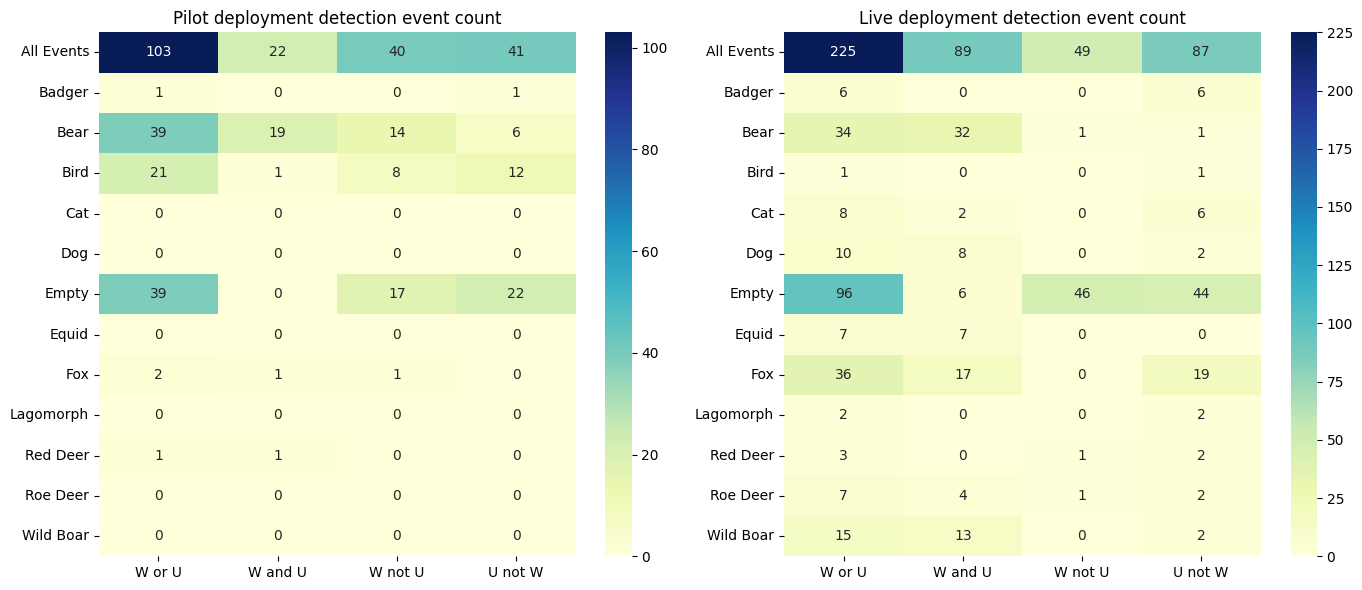

In [20]:
import pandas as pd

# Assume the dataframe 'df' already exists

# Exclude Human, Vehicle, and Unknown from the analysis
exclude_species = ["Human", "Vehicle", "Unknown"]
df_filtered = df[~df['Detection Event Primary Species'].isin(exclude_species)]

# Split the data into two periods
df_pilot = df_filtered[df_filtered['Date'] <= '2024-05-28']
df_live = df_filtered[df_filtered['Date'] >= '2024-05-29']

# Initialize the summary dictionary
summary = {
    'Detection Events': [],
    'W or U': [],
    'W and U': [],
    'W not U': [],
    'U not W': [],
    'W or U (Pilot)': [],
    'W and U (Pilot)': [],
    'W not U (Pilot)': [],
    'U not W (Pilot)': [],
    'W or U (Live)': [],
    'W and U (Live)': [],
    'W not U (Live)': [],
    'U not W (Live)': []
}

species_list = ['All Species'] + sorted(df_filtered['Detection Event Primary Species'].unique())

def calculate_metrics(df_period, species):
    if species == 'All Species':
        total_events = df_period['Detection Event ID'].nunique()
        w_events = df_period[df_period['Camera Make'] == 'Wilsus']['Detection Event ID'].unique()
        u_events = df_period[df_period['Camera Make'] == 'UOVision']['Detection Event ID'].unique()
    else:
        total_events = df_period[df_period['Detection Event Primary Species'] == species]['Detection Event ID'].nunique()
        w_events = df_period[(df_period['Camera Make'] == 'Wilsus') & (df_period['Detection Event Primary Species'] == species)]['Detection Event ID'].unique()
        u_events = df_period[(df_period['Camera Make'] == 'UOVision') & (df_period['Detection Event Primary Species'] == species)]['Detection Event ID'].unique()
    
    w_set = set(w_events)
    u_set = set(u_events)
    
    w_or_u = len(w_set | u_set)
    w_and_u = len(w_set & u_set)
    w_not_u = len(w_set - u_set)
    u_not_w = len(u_set - w_set)

    return total_events, w_or_u, w_and_u, w_not_u, u_not_w

for species in species_list:
    total_events, w_or_u, w_and_u, w_not_u, u_not_w = calculate_metrics(df_filtered, species)
    summary['Detection Events'].append(total_events)
    summary['W or U'].append(w_or_u)
    summary['W and U'].append(w_and_u)
    summary['W not U'].append(w_not_u)
    summary['U not W'].append(u_not_w)

    _, w_or_u_pilot, w_and_u_pilot, w_not_u_pilot, u_not_w_pilot = calculate_metrics(df_pilot, species)
    summary['W or U (Pilot)'].append(w_or_u_pilot)
    summary['W and U (Pilot)'].append(w_and_u_pilot)
    summary['W not U (Pilot)'].append(w_not_u_pilot)
    summary['U not W (Pilot)'].append(u_not_w_pilot)

    _, w_or_u_live, w_and_u_live, w_not_u_live, u_not_w_live = calculate_metrics(df_live, species)
    summary['W or U (Live)'].append(w_or_u_live)
    summary['W and U (Live)'].append(w_and_u_live)
    summary['W not U (Live)'].append(w_not_u_live)
    summary['U not W (Live)'].append(u_not_w_live)

summary_df = pd.DataFrame(summary, index=species_list)

# Display the summary table
display(summary_df)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'summary_df' already exists from the previous calculations

# Extract data for the heatmaps and rename columns to remove (Pilot) and (Live)
heatmap_data_pilot = summary_df[['W or U (Pilot)', 'W and U (Pilot)', 'W not U (Pilot)', 'U not W (Pilot)']]
heatmap_data_pilot.columns = ['W or U', 'W and U', 'W not U', 'U not W']

heatmap_data_live = summary_df[['W or U (Live)', 'W and U (Live)', 'W not U (Live)', 'U not W (Live)']]
heatmap_data_live.columns = ['W or U', 'W and U', 'W not U', 'U not W']

# Rename the index for "All Species" to "All Events"
heatmap_data_pilot = heatmap_data_pilot.rename(index={'All Species': 'All Events'})
heatmap_data_live = heatmap_data_live.rename(index={'All Species': 'All Events'})

# Create subplots for the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create heatmap for Pilot period
sns.heatmap(heatmap_data_pilot, annot=True, cmap='YlGnBu', fmt='d', ax=axes[0])
axes[0].set_title('Pilot deployment detection event count')

# Create heatmap for Live period
sns.heatmap(heatmap_data_live, annot=True, cmap='YlGnBu', fmt='d', ax=axes[1])
axes[1].set_title('Live deployment detection event count')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np

# Assume 'df' already exists

# Combine Date and Time into a single Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Exclude Human, Vehicle, Unknown, and Empty from the analysis
exclude_species = ["Human", "Vehicle", "Unknown", "Empty"]
df_filtered = df[~df['Detection Event Primary Species'].isin(exclude_species)]

# Split the data into two periods
df_pilot = df_filtered[df_filtered['Date'] <= '2024-05-28']
df_live = df_filtered[df_filtered['Date'] >= '2024-05-29']

# Helper function to calculate primary species
def calculate_primary_species(df, camera_make):
    species = df[df['Camera Make'] == camera_make]['Ground_Truth Primary Species']
    species = species[species != 'Empty']
    if species.empty:
        return ''
    return species.mode()[0]

# Function to create df_detection_events
def create_detection_events_df(df_period):
    return df_period.groupby('Detection Event ID', group_keys=False).apply(lambda x: pd.Series({
        'Detection Event Primary Species': x['Detection Event Primary Species'].iloc[0],
        'Detection Event Datetime': x['Datetime'].iloc[0],
        'Wilsus Primary Species': calculate_primary_species(x, 'Wilsus'),
        'UOVision Primary Species': calculate_primary_species(x, 'UOVision')
    })).reset_index()

# Create df_detection_events for both Pilot and Live periods
df_detection_events_pilot = create_detection_events_df(df_pilot)
df_detection_events_live = create_detection_events_df(df_live)

# Function to calculate recall and create summary
def calculate_recall_summary(df_detection_events):
    species_list = sorted(df_detection_events['Detection Event Primary Species'].unique())
    recall_summary = {
        'Species': [],
        'n': [],
        'Recall Wilsus': [],
        'Recall UOVision': []
    }

    for species in species_list:
        filtered_df = df_detection_events[df_detection_events['Detection Event Primary Species'] == species]
        support = len(filtered_df)
        
        recall_wilsus = (filtered_df['Wilsus Primary Species'] == species).sum() / support
        recall_uovision = (filtered_df['UOVision Primary Species'] == species).sum() / support
        
        recall_summary['Species'].append(species)
        recall_summary['n'].append(support)
        recall_summary['Recall Wilsus'].append(round(recall_wilsus, 4))
        recall_summary['Recall UOVision'].append(round(recall_uovision, 4))

    # Create recall DataFrame
    recall_df = pd.DataFrame(recall_summary)

    # Calculate micro, macro, and weighted recall
    micro_recall_wilsus = recall_df['Recall Wilsus'].mean()
    micro_recall_uovision = recall_df['Recall UOVision'].mean()

    weighted_recall_wilsus = (recall_df['Recall Wilsus'] * recall_df['n'] / recall_df['n'].sum()).sum()
    weighted_recall_uovision = (recall_df['Recall UOVision'] * recall_df['n'] / recall_df['n'].sum()).sum()

    recall_df.loc[len(recall_df.index)] = ['Micro', '-', round(micro_recall_wilsus, 4), round(micro_recall_uovision, 4)]
    recall_df.loc[len(recall_df.index)] = ['Macro', '-', round(micro_recall_wilsus, 4), round(micro_recall_uovision, 4)]
    recall_df.loc[len(recall_df.index)] = ['Weighted', '-', round(weighted_recall_wilsus, 4), round(weighted_recall_uovision, 4)]

    return recall_df

# Calculate recall summaries for both Pilot and Live periods
recall_summary_pilot = calculate_recall_summary(df_detection_events_pilot)
recall_summary_live = calculate_recall_summary(df_detection_events_live)

print("Pilot Recall Summary:")
display(recall_summary_pilot)
print("Live Recall Summary:")
display(recall_summary_live)


Pilot Recall Summary:


/tmp/ipykernel_19814/1724034937.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_period.groupby('Detection Event ID', group_keys=False).apply(lambda x: pd.Series({
/tmp/ipykernel_19814/1724034937.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_period.groupby('Detection Event ID', group_keys=False).apply(lambda x: pd.Series({


,Species,n,Recall Wilsus,Recall UOVision
0,Badger,1,0.0000,1.0000
1,Bear,39,0.8462,0.5641
2,Bird,21,0.4286,0.5714
3,Fox,2,0.5000,0.5000
4,Red Deer,1,1.0000,0.0000
5,Micro,-,0.5550,0.5271
6,Macro,-,0.5550,0.5271
7,Weighted,-,0.6875,0.5625


Live Recall Summary:


,Species,n,Recall Wilsus,Recall UOVision
0,Badger,6,0.0000,1.0000
1,Bear,34,0.9706,0.8529
2,Bird,1,0.0000,1.0000
3,Cat,8,0.2500,0.7500
4,Dog,10,0.8000,0.7000
5,Equid,7,1.0000,0.8571
6,Fox,36,0.4722,0.6111
7,Lagomorph,2,0.0000,1.0000
8,Red Deer,3,0.3333,0.6667
9,Roe Deer,7,0.7143,0.7143
